### Properties of inorganic chemical precursors

This Jupyter notebook cleans data imported from the CRC Handbook of Chemistry and Physics, 85th edition related to the solubility of various compounds. It then attempts to visualize general trends about chemical solubility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colNames = ['no', 'name', 'chemical_formula', 'CAS_no', 'mol_weight', 'physical_form', 'melting_point', 'boiling point', 
            'density', 'solubility_per_100gH2O', 'qualitative_solubility', 'blanks']
df = pd.read_csv('tabula-Inorganic_solubility_with_lines.tsv', sep='\t', names=colNames)
df = df.drop(labels='blanks', axis=1)
print(df.shape)

(2740, 11)


In [3]:
# Eliminate blank lines
df = df.dropna(axis=0, thresh=1)
df.shape

(2711, 11)

In [4]:
# Get rid of the header line that sometimes accompanies a new page
df = df[df.no != 'No.'] 
print(df.shape)
print(df.iloc[:,:2].tail(5))

(2681, 11)
        no                           name
2735  2677              Zirconium nitride
2736  2678            Zirconium phosphide
2737  2679             Zirconium silicide
2738  2680              Zirconyl chloride
2739  2681  Zirconyl chloride octahydrate


More cleaning required - some of the reference footnotes in the solubility column have been read in as actual numbers! Let's make a function that tries to eliminate 2 significant digits from the end of the number and see whether the result is zero. If it is, we'll assume that the number had no footnote; if it's not, we'll just use that number.

In [5]:
def clean_solubility_references(sol_str):
    ''' Clean reference superscript numbers from solubility values
    Attempts to clean the solubility string sol_str by removing the last two characters, 
    comparing the resulting number to zero.
        
    sol_str - string to be cleaned
    returns float
    '''
    if(len(str(sol_str)) < 3): return float(sol_str) # Don't try to convert an empty string to a float
    stripped_number = float(str(sol_str)[:-2]) 
    if stripped_number != 0: return stripped_number
    return float(sol_str)
        
df.solubility_per_100gH2O = df.solubility_per_100gH2O.apply(lambda x: clean_solubility_references(x) if(pd.notnull(x)) else x)

In [6]:
print(df[['name', 'solubility_per_100gH2O']][df.solubility_per_100gH2O.notnull()].head(10))
print(df.shape)
print(df[['solubility_per_100gH2O', 'name']].sort_values(by='solubility_per_100gH2O', ascending=False).head(5))
df.solubility_per_100gH2O.describe()

                                name  solubility_per_100gH2O
20                 Aluminum chloride                    45.1
21     Aluminum chloride hexahydrate                    45.1
24                 Aluminum fluoride                     0.5
25     Aluminum fluoride monohydrate                     0.5
26      Aluminum fluoride trihydrate                     0.5
35                  Aluminum nitrate                    68.9
36      Aluminum nitrate nonahydrate                    68.9
44  Aluminum perchlorate nonahydrate                   182.0
51                  Aluminum sulfate                    38.5
52  Aluminum sulfate octadecahydrate                    38.5
(2681, 11)
      solubility_per_100gH2O                                     name
1065                  1308.0                       Indium(III) iodide
181                    987.0                   Antimony(III) chloride
1671                   709.0  Diphosphoric acid (pyrophosphoric acid)
590                    573.0          

count     735.000000
mean       72.683508
std       111.089021
min         0.000001
25%         1.085000
50%        37.000000
75%       101.000000
max      1308.000000
Name: solubility_per_100gH2O, dtype: float64

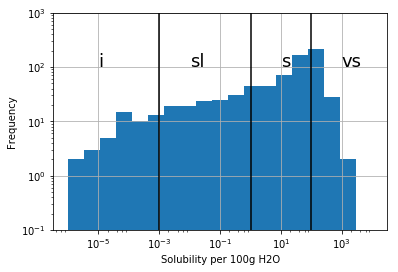

In [7]:
log_bins = np.logspace(-6, 4, num=20)
df.solubility_per_100gH2O.hist(bins=log_bins)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Solubility per 100g H2O')
plt.ylabel('Frequency')
plt.vlines([1e-3, 1, 100], 1e-1, 1e3)
plt.ylim([1e-1, 1e3])
plt.text(1e-5, 1e2, 'i', fontsize=18)
plt.text(1e-2, 1e2, 'sl', fontsize=18)
plt.text(1e1, 1e2, 's', fontsize=18)
plt.text(1e3, 1e2, 'vs', fontsize=18)
plt.show()

Qualitative solubility limits:
* vs - very soluble - > 100g per 100g H2O
* s - soluble - 1-100g per 100g H2O
* sl - slightly soluble - 1e-3g - 1g per 100g H2O
* i - insoluble - less than 1e-3g per 100g H2O

Let's parse the qualitative solubility next. Where solubility is indicated, there is a marker (e.g. s for soluble, i for insoluble) followed by a list of solvents, then a semi-colon separator for listing other qualitative solubilities.

In [8]:
def parse_qualsol(qs_str):
    '''Parse a qualitative solubility string
    input - qs_str (string) - qualitative solubility string
    output - sols (dict) - dictionary with solvent as key, qualitative solubility as value
    '''
    sols = dict()
    for solubility in qs_str.split(';'): # First parse each solubility classifier
        items = solubility.strip().split(' ')
        qs = items[0]
        solvents = ' '.join(items[1:]).split(',')
        for solvent in solvents: # Then add each solvent
            # Clean up some spacing issues
            if ('H 4' in solvent or 'H 2' in solvent): solvent = solvent.replace('H ', 'H')
            sols[solvent.lstrip()] = qs
    return sols
            
qsseries = df.qualitative_solubility[df.qualitative_solubility.notnull()].apply(parse_qualsol)
td = dict()
for entry in qsseries:
    for key, value in entry.items():
        td.setdefault(key, []).append(value)
td.keys()


dict_keys(['H2O', 'acid', 'alk', 'EtOH', 'dil HCl', 'bz', 'tol', 'CS2', 'ctc', 'chl', 'eth', 'xyl', 'ace', 'pyr', 'os', 'peth', 'MeOH', 'py', 'et', 'ct', 'dil acid', 'conc HCl', 'hc', 'bz. tol', 'HNO3', 'diox', 'hot H2O', 'conc HNO3', 'HCl', 'alk iodide soln', 'H2O (exp)', 'NH4OH', 'conc acid', 'cold H2O', 'thf', 'hot acid', 'aqua regia', 'hot HCl', 'hot conc acid', 'KCN soln', 'conc alk', 'dil H2SO4', 'HOAc', 'CN soln', 'HF', 'dil HNO3', 'dil HF', 'hot EtOH', 'NaOH', 'dil acids', 'KCNS', 'warm acid', 'CC4l', 'dil alk', 'DMF', 'DMSO', 'sl aqua regia', 'EtOh', 'reac acid', 'H2SO4', 'of SO2 in H2O', 'HF-HNO3 mixture', 'hot conc alk', 'hot HF', 'HNO3/HF', 'eth chl', 'EtAc', 'bz chl', 'conc HF'])

Let's find the qualitative solubilities with the most entries to see whether we have enough data points to do anything useful.

In [9]:
nEntries = []
for key, value in td.items():
    nEntries.append((len(value), key))
sorted(nEntries, reverse=True)[:5]

[(1246, 'H2O'), (713, 'EtOH'), (233, 'acid'), (169, 'eth'), (121, 'ace')]

For now, let's only look at water solubility and leave other solubility to further analysis. Let's combine all of the water solubility information we have into a useful dataframe.

In [ ]:
class Element:
    
    def __init__(self, name):
        
        self.name = name
        self.atomic_number = get_atomic_number(name)
        self.row = get_row(atomic_number)
        self.col = get_group(atomic_number)
        
    
    def get_row(at_no):
        '''Get the (visual) row for a given element's atomic number
        input: at_no (int) - atomic number
        output: (int) - visual row'''
        if at_no < 3: return 1
        if at_no < 11: return 2
        if at_no < 19: return 3
        if at_no < 37: return 4
        if at_no < 55: return 5
        if at_no < 57: return 6
        if at_no < 72: return 9 # Lanthanides
        if at_no < 87: return 6
        if at_no < 89: return 7 
        if at_no < 104: return 10 # Actinides
        else: return 7
    
    def get_group(at_no):
        '''Get the (visual) column/group for a given element atomic number
        input: at_no (int) - atomic number
        output: (int) - visual column/group'''
        firsts = [1,3,11,19,37,55,87]
        if at_no in [1, 3, 11, 19, 37, 55, 87]: return 1
        if at_no in (firsts[1:] + 1): return 2
        for i in range(3, 13):
            if(at_no) in ([+ i): return i
        group_13 = [5, 13, 31, 49, 81, 113]

First, let's look at what types of chemicals we have.

In [23]:
df.name = df.name.str.replace('\n', ' ')
df[df.name.str.contains(' nitrate')].name

35                          Aluminum nitrate
36              Aluminum nitrate nonahydrate
76               Ammonium cerium(IV) nitrate
135                         Ammonium nitrate
270                           Barium nitrate
333             Beryllium nitrate trihydrate
354             Bismuth nitrate pentahydrate
437                          Cadmium nitrate
438             Cadmium nitrate tetrahydrate
495                          Calcium nitrate
496             Calcium nitrate tetrahydrate
573          Cerium(III) nitrate hexahydrate
600                           Cesium nitrate
658                    Chromium(III) nitrate
660        Chromium(III) nitrate nonahydrate
719                       Cobalt(II) nitrate
720           Cobalt(II) nitrate hexahydrate
746                      Cobalt(III) nitrate
815                       Copper(II) nitrate
816           Copper(II) nitrate hexahydrate
817            Copper(II) nitrate trihydrate
853     Dysprosium(III) nitrate pentahydrate
865       

Need to figure out a way to parse oxidation state from the name
Need to figure out a way to combine hydrate, non-hydrate information
Need to get group, period data for plotting

## Plotting
We can use the heatmap from the seaborn library to show our solubility information. This requires a little creative plotting to account for elements which have precursors with multiple oxidation states. We use a (2N, 2N) numpy ndarray to represent up to 4 possible oxidation states for each element. Then we mask over the periodic table and make some code to plot the qualitative solubility of an element belonging to a certain group of precursors (e.g. nitrates).

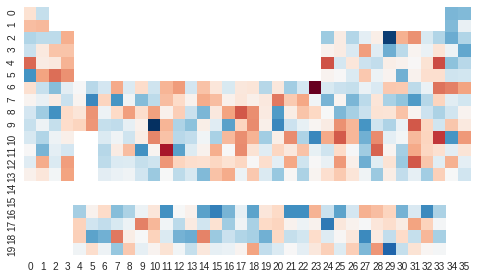

In [28]:
import seaborn as sns

ptable = np.random.randn(20, 36)
mask = np.zeros_like(ptable)
mask[0:2,2:34] = True
mask[2:4,4:24] = True
mask[4:6,4:24] = True
mask[10:12,4:6] = True
mask[12:14,4:6] = True
mask[14:16,:] = True
mask[16:18,pd.np.r_[0:4,34:36]] = True
mask[18:20,pd.np.r_[0:4,34:36]] = True
with sns.axes_style("white"):
     ax = sns.heatmap(ptable, mask=mask, linecolor='k', linewidths=0.0,vmax=.3, square=True, cbar=False)
plt.show()

For parsing out the oxidation state and hydration state, let's make a class called element that allows us to set some parameters